In [13]:
seed = 42                           #we set the seed for the random aspect.

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings                     #ignore the warnings for a cleaner output.
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# !pip install tensorflow==2.14.0    #2.14 is necessary for ConvNeXt. For some reason.
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler        #this oversampler will be useful in preprocessing.
from imblearn.combine import SMOTETomek

In [14]:
training_data = np.load('/kaggle/input/time-series/training_data.npy', allow_pickle=True)
categories = np.load('/kaggle/input/time-series/categories.npy', allow_pickle=True)
valid_periods = np.load('/kaggle/input/time-series/valid_periods.npy', allow_pickle=True)

print(training_data.shape)
print(training_data[0, valid_periods[0, 0]:valid_periods[0, 1]].shape)

(48000, 2776)
(451,)


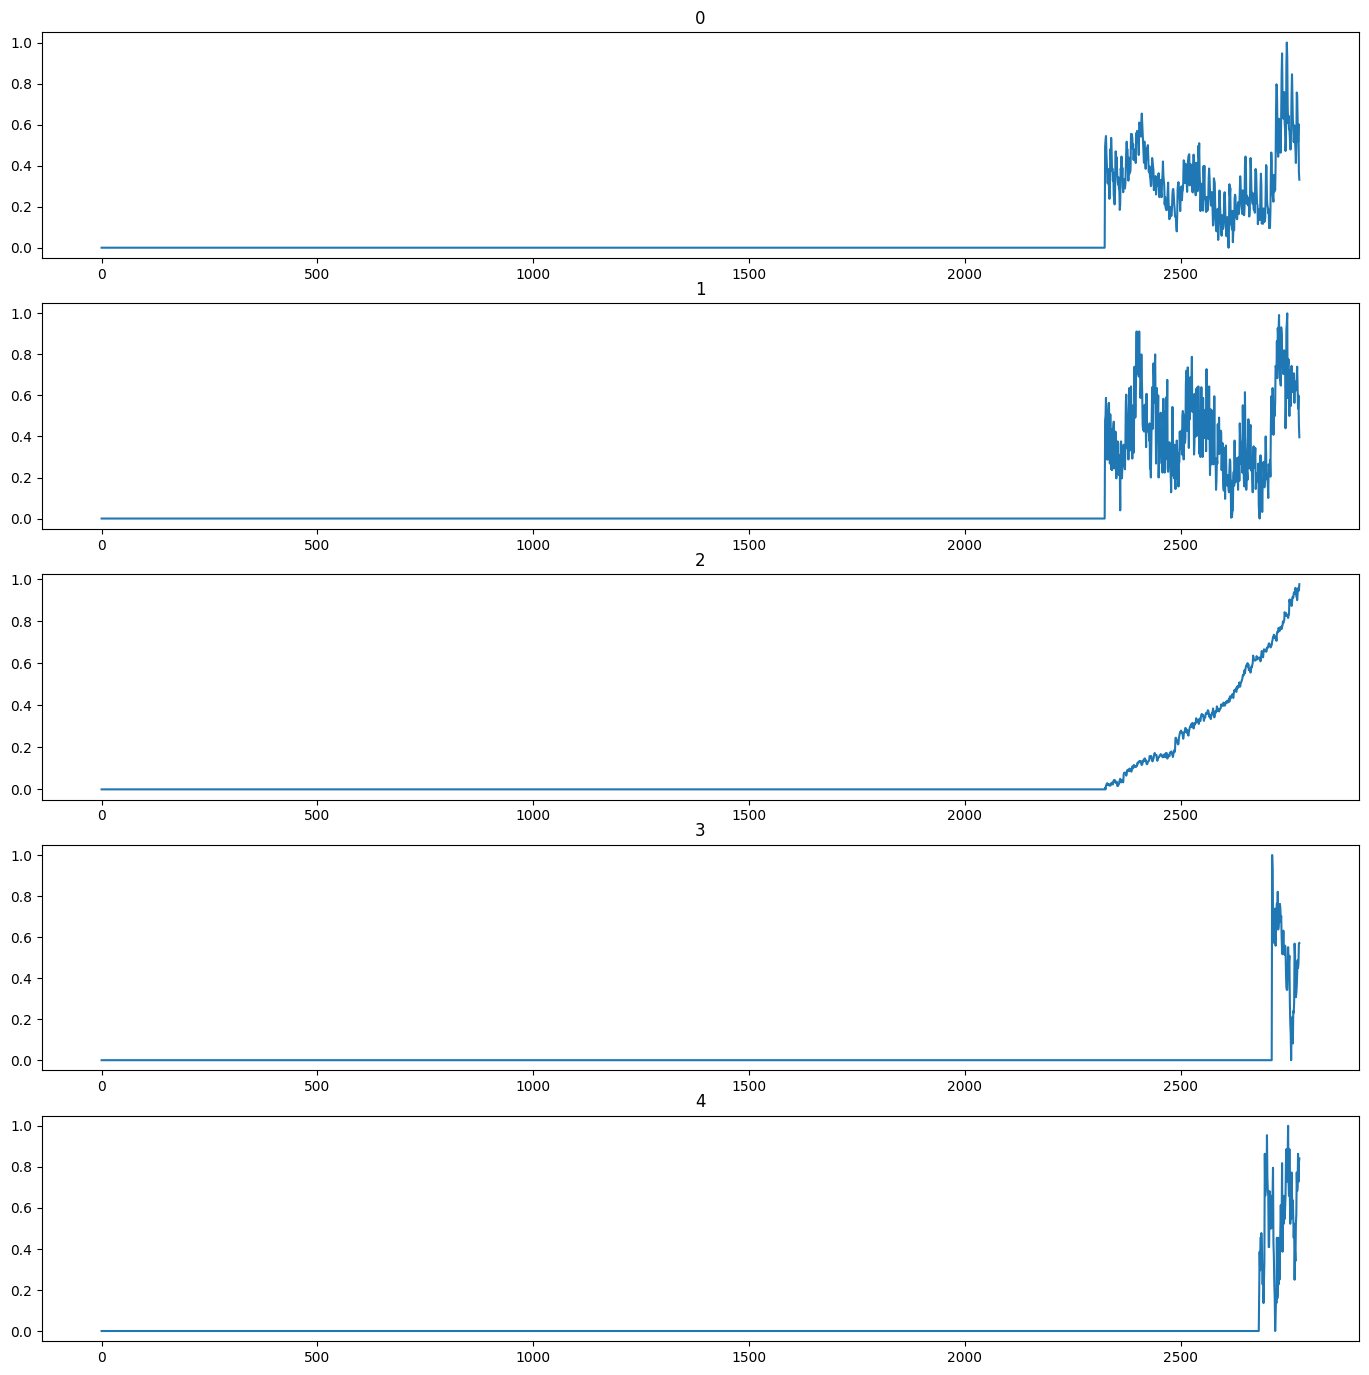

In [15]:
n_plots = 5

def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(columns, 1, figsize=(17,17))
    for i in range(columns):
        axs[i].plot(df[i])
        axs[i].set_title(i)
    plt.show()
    
inspect_dataframe(training_data[:n_plots], n_plots)

# Forecasting

In [16]:
label_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}
encoded = np.vectorize(label_mapping.get)(categories)

print(encoded.shape)

finalized_train = []

for i in range(training_data.shape[0]):
    timeseries = training_data[i]
    label = encoded[i]
    category_info = np.zeros((timeseries.shape[0], 6))
    category_info[:, int(label)] = 1
    relevant_sequence = np.expand_dims(timeseries, axis=-1)
    input_sequence = np.concatenate([relevant_sequence, category_info], axis=-1)
    finalized_train.append(input_sequence)

training_data = np.array(finalized_train)
del finalized_train
del input_sequence
del encoded

print(training_data.shape)

(48000,)
(48000, 2776, 7)


In [17]:
test_size = 0.1
slice_i = -int(training_data.shape[0] *(test_size))
X_test_raw = training_data[:-slice_i]
training_data = training_data[-slice_i:]
X_val_raw = training_data[:-slice_i]
X_train_raw = training_data[-slice_i:]

del training_data

print("Training Data Shape:", X_train_raw.shape)
print("Test Data Shape:", X_test_raw.shape)
print("Validation Data Shape:", X_val_raw.shape)

Training Data Shape: (38400, 2776, 7)
Test Data Shape: (4800, 2776, 7)
Validation Data Shape: (4800, 2776, 7)


In [18]:
def build_sequences(temp_df, window=150, stride=50, telescope=9):
    assert window % stride == 0
    X = []
    y = []
    padding_check = temp_df.shape[1] % window

    if (padding_check != 0):
        padding_len = window - temp_df.shape[1] % window
        padding = np.zeros((temp_df.shape[0], padding_len, 7), dtype='float32')
        temp_df = np.concatenate((padding, temp_df), axis = 1)
        del padding
        assert temp_df.shape[1] % window == 0

    for j in np.arange(temp_df.shape[0]):
        start = valid_periods[j, 0] + padding_len
        if j == 0:
            print('start', start)
            print(valid_periods[j, 1])
            print(temp_df.shape[1])
            
        length = valid_periods[j, 1] - valid_periods[j, 0]
        if j == 0:
            print('length', length)
            
        start -= window - (length % window)
        
        if j == 0:
            print('start', start)
            print('total', temp_df.shape[1] - start)
        
        for i in np.arange(start, temp_df.shape[1] - window - telescope, stride): 
            X.append(temp_df[j, i:i + window])
            y.append(temp_df[j, i + window:i + window + telescope])
    
    print('finishhhh')
    del temp_df
    X = np.array(X)
    print('YO')
    y = np.array(y)
    return X, y

In [19]:
X_train, y_train = build_sequences(X_train_raw)
del X_train_raw
X_train.shape
print('done')
X_val, y_val = build_sequences(X_val_raw)
del X_val_raw
print('done')
X_test, y_test = build_sequences(X_test_raw)
del X_test_raw
print('done')

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

start 2399
2776
2850
length 451
start 2250
total 600
finishhhh
YO
done
start 2399
2776
2850
length 451
start 2250
total 600
finishhhh
YO
done
start 2399
2776
2850
length 451
start 2250
total 600
finishhhh
YO
done
(101016, 150, 7) (101016, 9, 7) (19422, 150, 7) (19422, 9, 7) (19422, 150, 7) (19422, 9, 7)


In [20]:
def build_model(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = tfkl.LSTM(200, return_sequences=True, input_shape=input_shape)(input_layer)
    x = tfkl.Dropout(0.2)(x)
    x = tfkl.LSTM(100, return_sequences=True)(x)
    x = tfkl.Dropout(0.2)(x)
    # Add an attention layer
    x = tfkl.Attention()([x, x])
    x = tfkl.Dense(50, activation='relu')(x)
    x = tfkl.Dense(output_shape, activation='linear')(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=x, name='CONV_LSTM_model')
 
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam()) 
 
    return model

In [21]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]
print(input_shape)

model = build_model(input_shape, output_shape)
model.summary()

(150, 7)
Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 150, 7)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 150, 100)          43200     
                                                                 
 dense_1 (Dense)             (None, 150, 9)            909       
                                                                 
 output_layer (Conv1D)       (None, 150, 1)            28        
                                                                 
 cropping (Cropping1D)       (None, 9, 1)              0         
                                                                 
Total params: 44137 (172.41 KB)
Trainable params: 44137 (172.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (X_val, y_val),
    verbose=1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]).history

Epoch 1/200
1579/1579 [==============================] - 20s 11ms/step - loss: 0.1337 - val_loss: 0.1321 - lr: 0.0010
Epoch 2/200
1579/1579 [==============================] - 17s 11ms/step - loss: 0.1336 - val_loss: 0.1320 - lr: 0.0010
Epoch 3/200
1579/1579 [==============================] - 18s 11ms/step - loss: 0.1336 - val_loss: 0.1323 - lr: 0.0010
Epoch 4/200
1579/1579 [==============================] - 17s 11ms/step - loss: 0.1336 - val_loss: 0.1320 - lr: 0.0010
Epoch 5/200
1579/1579 [==============================] - 17s 11ms/step - loss: 0.1335 - val_loss: 0.1322 - lr: 0.0010
Epoch 6/200
1579/1579 [==============================] - 17s 11ms/step - loss: 0.1335 - val_loss: 0.1321 - lr: 0.0010
Epoch 7/200
1579/1579 [==============================] - 17s 11ms/step - loss: 0.1335 - val_loss: 0.1321 - lr: 0.0010
Epoch 8/200
1579/1579 [==============================] - 17s 11ms/step - loss: 0.1335 - val_loss: 0.1320 - lr: 0.0010
Epoch 9/200
1579/1579 [==============================] -

KeyboardInterrupt: 

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [24]:
#model.save('DirectForecasting')
model = tfk.models.load_model('DirectForecasting')

In [ ]:
t = X_test[:, :, :]
y_t = y_test[:, :, :]
t.shape, y_t.shape

In [ ]:
# Predict the test set using the model
predictions = model.predict(t, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_t.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_t.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

In [ ]:
for i in range(4000, 4005):
    my_test = y_test[i, -1]
    my_pred = predictions[i, -1]
    
    print(my_pred.shape)
    
    plt.figure(figsize=(17,4))
    plt.plot(my_test, label='test', alpha=.8, color='#ff7f0e')
    plt.plot(my_pred, label='pred', alpha=.9, color='#5a9aa5')
    plt.title('Results')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

In [1]:
import requests

github_username = 'lorenzo-morelli'
repo_name = 'ANN'
file_path = 'current_model.py'

raw_url = f'https://raw.githubusercontent.com/{github_username}/{repo_name}/main/{file_path}'

try:
    response = requests.get(raw_url)
    response.raise_for_status()  # Check if the request was successful

    with open('/kaggle/working/model.py', 'w') as file:
        file.write(response.text)
        
    with open('/kaggle/working/metadata', 'w') as file:
        file.write('')

    print(f'Successfully created model.py from {raw_url}')
except requests.exceptions.RequestException as e:
    print(f'Error fetching content from {raw_url}: {e}')

!cd /kaggle/working/

!mv DirectForecasting SubmissionModel
!zip -r -f submission.zip SubmissionModel
!zip submission.zip model.py
!zip submission.zip metadata

from IPython.display import FileLink
FileLink(r'submission.zip')

Successfully created model.py from https://raw.githubusercontent.com/lorenzo-morelli/ANN/main/current_model.py
mv: cannot stat 'DirectForecasting': No such file or directory
freshening: SubmissionModel/ (stored 0%)
freshening: SubmissionModel/variables/ (stored 0%)
freshening: SubmissionModel/variables/variables.data-00000-of-00001 (deflated 6%)
freshening: SubmissionModel/variables/variables.index (deflated 58%)
freshening: SubmissionModel/saved_model.pb (deflated 89%)
freshening: SubmissionModel/fingerprint.pb (stored 0%)
freshening: SubmissionModel/keras_metadata.pb (deflated 88%)
updating: model.py (deflated 55%)
updating: metadata (stored 0%)


/kaggle/working/submission.zip